# Wildfire Image Classification

As we saw in the [image analysis](01-image-analysis.ipynb) the 1900 images dataset about forest fires contains 1832 images for training and 68 images for testing. The dataset includes two class labels: 'fire' and 'nofire'. The 'fire' class pertains to images that depict a forest fire, while the 'nofire' class pertains to images that do not depict a forest fire. These images can be used to train machine learning models to detect forest fires in images.

## Visualize the data

Visualizing this dataset can help in understanding the distribution of the data and identifying any potential issues such as class imbalance. One way to visualize this data is to create a bar chart showing the number of images in each class (fire and nofire). Additionally, it would be beneficial to randomly select and display a few images from each class to gain a sense of the visual characteristics of the data. It can provide insights into the dataset and can inform decisions on how to preprocess and augment the data before training a model.

In [1]:
# Import required libraries
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import tensorflow as tf

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [2]:
# Walk through forest_fire/training_and_validation directory
# and list number of sub-directories
for path, dirs, files in os.walk('../dataset/forest_fire/training_and_validation'):
    print(f"There are {len(dirs)} directories and {len(files)} images in '{path}'.")

There are 2 directories and 0 images in '../dataset/forest_fire/training_and_validation'.
There are 0 directories and 928 images in '../dataset/forest_fire/training_and_validation\fire'.
There are 0 directories and 904 images in '../dataset/forest_fire/training_and_validation\nofire'.


In [3]:
# Create train and test paths
train_dir = '../dataset/forest_fire/training_and_validation'
test_dir = '../dataset/forest_fire/testing'

In [4]:
# Extract class names from train_dir
class_dir = Path(train_dir)
class_names = np.array(sorted([item.name for item in class_dir.glob('*')]))
print(class_names)

['fire' 'nofire']


In [5]:
# Get the images distribution in each class in train_dir
for i in class_names:
    print(f"Training {i} images are {len(os.listdir(train_dir+'/'+i+'/'))}")

Training fire images are 928
Training nofire images are 904


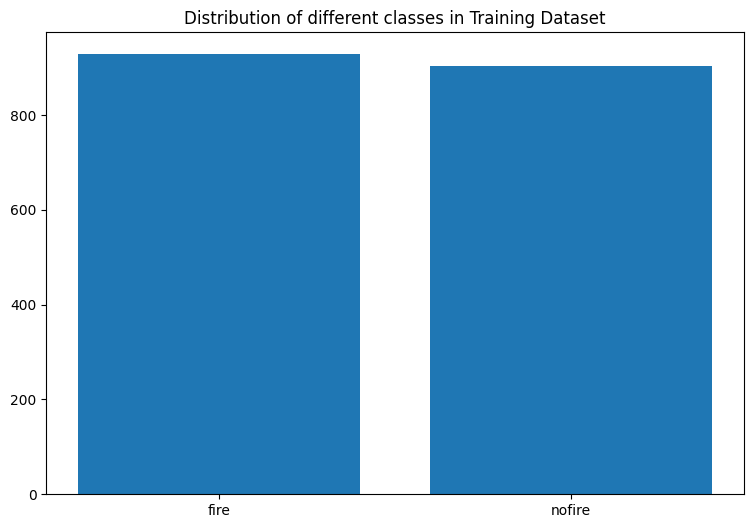

In [6]:
# Count images in each class directory (train)
num_imgs = {}
for i in class_names:
    images_count = len(os.listdir(train_dir+'/'+i+'/'))
    num_imgs[i] = images_count

# Plot distribution
plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(num_imgs)), list(num_imgs.values()), align='center')
plt.xticks(np.arange(len(num_imgs)), list(num_imgs.keys()))
plt.title('Distribution of different classes in Training Dataset')

plt.show()

The 1832 training images in the forest fire dataset are distributed among the two classes 'fire' and 'nofire'. Specifically, 928 images belong to the 'fire' class, which depicts forest fires, and 904 images belong to the 'nofire' class, which do not depict forest fires. The training images are used to train machine learning models to detect forest fires in images. With this data distribution, the model should have a good balance of examples for both classes, which will help the model generalize better to new unseen data.

Test fire images are 22
Test nofire images are 46


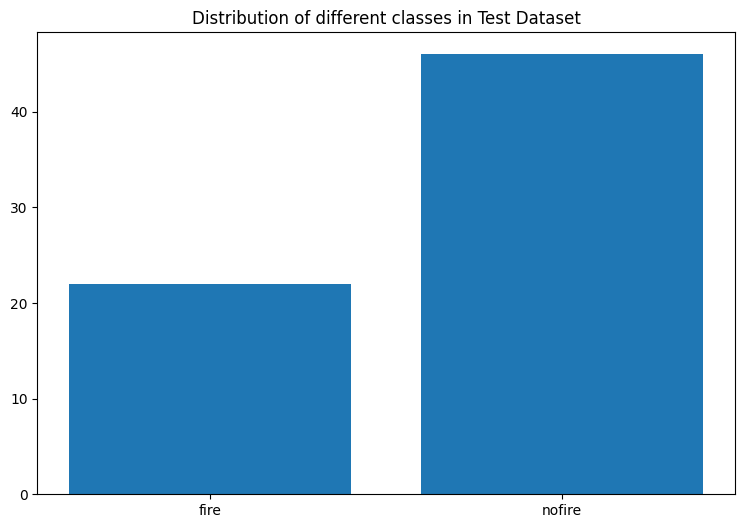

In [7]:
# Get the images distribution in each class in test_dir
for i in class_names:
    print(f"Test {i} images are {len(os.listdir(test_dir+'/'+i+'/'))}")
    
# Count images in each class directory (test)
num_imgs = {}
for i in class_names:
    images_count = len(os.listdir(test_dir+'/'+i+'/'))
    num_imgs[i] = images_count

# Plot distribution
plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(num_imgs)), list(num_imgs.values()), align='center')
plt.xticks(np.arange(len(num_imgs)), list(num_imgs.keys()))
plt.title('Distribution of different classes in Test Dataset')

plt.show()

The 68 test images in the forest fire dataset are distributed among the two classes 'fire' and 'nofire'. Specifically, 22 images belong to the 'fire' class, which depicts forest fires, and 46 images belong to the 'nofire' class, which do not depict forest fires. The test images are used to evaluate the performance of a machine learning model trained on the training images. With this data distribution, the model would be tested on a slightly higher proportion of 'nofire' images as compared to 'fire' images, which will give a better idea of how well the model can generalize to unseen images, especially when the majority of images in the real world are 'nofire' images.

To gain a better understanding of the data, let's take a look at a selection of random images from both classes.

In [7]:
# Function to load random image
def load_random_image(target_dir, target_class):
    # Setup target directory
    target_folder = target_dir + '/' + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)  # reads from list of images and randomly sample them

    # Read in the image and plot it using matplotlib
    filename = target_folder + '/' + random_image[0]  # returns an image file name
    img = mpimg.imread(filename)

    return img

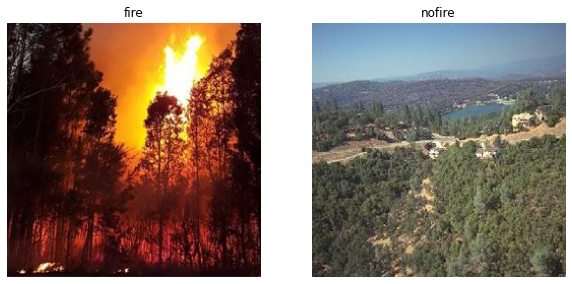

In [8]:
# Create the subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the random images from each class (fire, nofire)
for i, target_class in enumerate(class_names):
    img = load_random_image(train_dir, target_class)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(target_class)

plt.show()

## Preprocess the data

The image data preprocessing involves a series of steps to prepare the data for model training. In our first step we'll resize the images to a consistent size of (150, 150) pixels. This is done to ensure that all images have the same dimensions and can be processed by the model in a consistent manner. The batch size used for training is 8, which means that 8 images will be processed at a time during training.

The Xception preprocess input function is used to preprocess the data by normalizing it, this is a pre-processing technique to standardize the input data to the model. It is a common practice to use a pre-trained model to extract features from the data before training a new model.

Finally, the test is used to evaluate the performance of the model during training.

In [9]:
# Image and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 8

# Create image data generator for model training and validation
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Import train data from directory and turn it into batches
train_ds = datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical')

# Validation data
val_ds = datagen.flow_from_directory(directory=test_dir,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                          class_mode='categorical',
                                          shuffle=False)

Found 1832 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


## Build baseline model

To build a baseline model using `Xception` in TensorFlow's Keras, the pre-trained Xception model is imported from the [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module. The pre-trained weights are loaded and the last layers are removed and replaced with a new fully connected layer with number of neurons equal to `2` and the `softmax` activation function. The model is then compiled with an `Adam` optimizer, `categorical crossentropy` function and `accuracy` metrics, and it's ready to be fine-tuned or trained on the specific dataset.

In [10]:
# Function to create model
def define_model():
    # Build base model
    base_model = tf.keras.applications.xception.Xception(include_top=False)
    # Freeze the convolutional base by preventing the weights being updated during training
    base_model.trainable = False

    # Define expected image shape as input
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    # Feed inputs to the base model
    x = base_model(inputs, training=False) # set False because the model contains BatchNormalization layer
    # Convert matrices into feature vectors using pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Create dense layer (two nodes, 'softmax' activation)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create model for training
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
    
    return model

In [11]:
# Create baseline model
baseline_model = define_model()

2023-01-21 15:20:46.921372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 15:20:47.009363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 15:20:47.010134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 15:20:47.011822: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


In [12]:
# Train model for 10 epochs
baseline_history = baseline_model.fit(train_ds,
                                       epochs=10,
                                       validation_data=val_ds)

2023-01-21 15:21:02.396577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-21 15:21:05.448558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


229/229 [==============================] - 22s 59ms/step - loss: 0.1091 - accuracy: 0.9662 - val_loss: 0.0556 - val_accuracy: 0.9706
Epoch 2/10
229/229 [==============================] - 5s 24ms/step - loss: 0.0448 - accuracy: 0.9874 - val_loss: 0.0446 - val_accuracy: 0.9853
Epoch 3/10
229/229 [==============================] - 5s 24ms/step - loss: 0.0343 - accuracy: 0.9896 - val_loss: 0.0479 - val_accuracy: 0.9853
Epoch 4/10
229/229 [==============================] - 6s 24ms/step - loss: 0.0256 - accuracy: 0.9940 - val_loss: 0.0308 - val_accuracy: 0.9853
Epoch 5/10
229/229 [==============================] - 5s 23ms/step - loss: 0.0203 - accuracy: 0.9962 - val_loss: 0.0467 - val_accuracy: 0.9853
Epoch 6/10
229/229 [==============================] - 5s 24ms/step - loss: 0.0164 - accuracy: 0.9962 - val_loss: 0.0453 - val_accuracy: 0.9853
Epoch 7/10
229/229 [==============================] - 6s 25ms/step - loss: 0.0139 - accuracy: 0.9967 - val_loss: 0.0421 - val_accuracy: 0.9853
Epoch 8/1

In [13]:
# Evaluate baseline model
baseline_model.evaluate(val_ds)

9/9 [==============================] - 0s 20ms/step - loss: 0.0479 - accuracy: 0.9853


[0.04788278788328171, 0.9852941036224365]

The baseline_model evaluation on the validation set resulted in an accuracy of 0.98. The next step is to try to improve this accuracy by experimenting with different techniques. To evaluate the performance of the model, it's important to visualize the history of the training, like accuracy and loss curve, this can be done by using the `history` object returned by the `fit()` method of the model, this will help to identify any overfitting or underfitting during training.

Let's visualize the loss curves of baseline model.

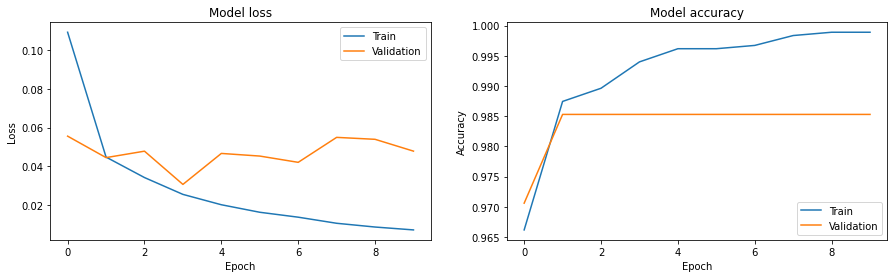

In [14]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot the training and validation loss
ax1.plot(baseline_history.history['loss'])
ax1.plot(baseline_history.history['val_loss'])
ax1.set_title('Model loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper right')

# Plot the training and validation accuracy
ax2.plot(baseline_history.history['accuracy'])
ax2.plot(baseline_history.history['val_accuracy'])
ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='lower right')

# Show the figure
plt.show()

It appears that the model's accuracy plateaued at around 98% after the first training epoch. Our first experiment aims to enhance the model's accuracy by adjusting the learning rate.

## Adjusting the learning rate

In the first experiment, we will be systematically testing the model's performance with different learning rates. Specifically, we will loop over the learning rates of 0.0001, 0.001, 0.01, and 0.1. The goal of this experiment is to find the best learning rate for the model, by training the model with different learning rates and evaluating the performance on the validation set. The learning rate that results in the best performance on the validation set will be chosen as the optimal learning rate for the model.

In [15]:
# Function to define model with learning rate
def define_model(learning_rate=0.001):
    # Build base model
    base_model = tf.keras.applications.xception.Xception(include_top=False)
    base_model.trainable = False
    
    # Create input and output layer
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create model for training
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])
    
    return model

In [16]:
# Dictionary to store history with different learning rates
scores = {}

# List of learning rates
lrs = [0.0001, 0.001, 0.01, 0.1]

for lr in lrs:
    print(f'Learning rate {lr}')
    
    model = define_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print()
    print()

Learning rate 0.0001
Epoch 1/10
229/229 [==============================] - 8s 27ms/step - loss: 0.3013 - accuracy: 0.8947 - val_loss: 0.2337 - val_accuracy: 0.9412
Epoch 2/10
229/229 [==============================] - 6s 24ms/step - loss: 0.1439 - accuracy: 0.9760 - val_loss: 0.1336 - val_accuracy: 0.9853
Epoch 3/10
229/229 [==============================] - 5s 23ms/step - loss: 0.1047 - accuracy: 0.9820 - val_loss: 0.0946 - val_accuracy: 0.9853
Epoch 4/10
229/229 [==============================] - 6s 26ms/step - loss: 0.0851 - accuracy: 0.9842 - val_loss: 0.0760 - val_accuracy: 0.9853
Epoch 5/10
229/229 [==============================] - 5s 23ms/step - loss: 0.0728 - accuracy: 0.9858 - val_loss: 0.0657 - val_accuracy: 0.9853
Epoch 6/10
229/229 [==============================] - 5s 24ms/step - loss: 0.0643 - accuracy: 0.9853 - val_loss: 0.0569 - val_accuracy: 0.9853
Epoch 7/10
229/229 [==============================] - 5s 23ms/step - loss: 0.0582 - accuracy: 0.9880 - val_loss: 0.0508 -

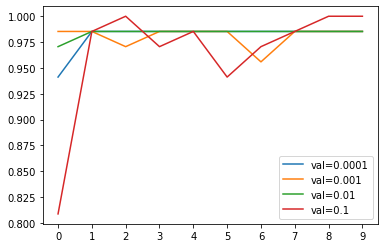

In [18]:
for lr, hist in scores.items():
#     # Visualize training accuracy
#     plt.plot(hist['accuracy'], label=f'train={lr}')
    # Visualize validation accuracy
    plt.plot(hist['val_accuracy'], label=f'val={lr}')
    
plt.xticks(np.arange(10))
plt.legend()

plt.show()

In order to have a clearer understanding and visualization of the learning curves, we will eliminate the two learning rates that did not perform well during the experiment.

In [19]:
# Remove two worst learning rates from scores dict
del scores[0.01]
del scores[0.0001]

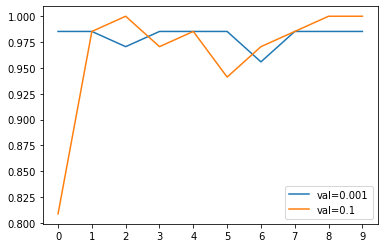

In [22]:
for lr, hist in scores.items():
#     # Visualize training accuracy
#     plt.plot(hist['accuracy'], label=f'train={lr}')
    # Visualize validation accuracy
    plt.plot(hist['val_accuracy'], label=f'val={lr}')
    
plt.xticks(np.arange(10))
plt.legend()

plt.show()

After conducting the experiment, we have determined that the best learning rate for the model is `0.1`. This learning rate has resulted in the best performance on the validation set. In our next experiment, we will use this learning rate as a starting point and continue to optimize the model's performance.

In [23]:
# Best learning rate value
learning_rate = 0.1

## Checkpoint

We'll used the checkpoint to save the best model during training by monitoring the validation accuracy, it's done by using ModelCheckpoint callback in Keras, which saves the model's state only when validation accuracy improves, this is useful to prevent overfitting. All models will be store in the `checkpoint` directory.

In [24]:
# Create checkpoint to save best model
filepath = './checkpoint/xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_best_only=True, # save the best model only
                                                 monitor='val_accuracy',
                                                 mode='max')

In [25]:
# Define model with best learning rate
model = define_model(learning_rate=learning_rate)

# Train model with checkpoint
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/10
229/229 [==============================] - 8s 26ms/step - loss: 1.1789 - accuracy: 0.9618 - val_loss: 0.3235 - val_accuracy: 0.9853


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
229/229 [==============================] - 5s 24ms/step - loss: 1.0052 - accuracy: 0.9814 - val_loss: 1.2361 - val_accuracy: 0.9706
Epoch 3/10
229/229 [==============================] - 5s 22ms/step - loss: 0.4308 - accuracy: 0.9896 - val_loss: 1.6317 - val_accuracy: 0.9706
Epoch 4/10
229/229 [==============================] - 6s 24ms/step - loss: 0.2928 - accuracy: 0.9907 - val_loss: 0.1167 - val_accuracy: 0.9853
Epoch 5/10
229/229 [==============================] - 6s 25ms/step - loss: 0.4265 - accuracy: 0.9891 - val_loss: 0.3971 - val_accuracy: 0.9853
Epoch 6/10
229/229 [==============================] - 6s 24ms/step - loss: 0.2307 - accuracy: 0.9924 - val_loss: 0.4875 - val_accuracy: 0.9706
Epoch 7/10
229/229 [==============================] - 5s 22ms/step - loss: 0.2360 - accuracy: 0.9940 - val_loss: 2.4111 - val_accuracy: 0.9412
Epoch 8/10
229/229 [==============================] - 5s 24ms/step - loss: 0.1721 - accuracy: 0.9956 - val_loss: 0.0033 - val_accuracy: 1.0000

## Add more layers

The next experiment aims to improve the model's performance by adding an extra dense layer and testing different number of neurons from 10, 100 and 1000, this will help to identify the optimal number of neurons that results in the best performance on the validation set, and understand the impact of the number of neurons on the model's performance.

In [27]:
# Function to define model with learning rate and dense layer
def define_model(learning_rate=0.001, size_inner=100):
    # Build base model
    base_model = tf.keras.applications.xception.Xception(include_top=False)
    base_model.trainable = False
    
    # Create input and output layer
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(size_inner, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create model for training
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])
    
    return model

In [28]:
# Create checkpoint to save best model for version 2
filepath = './checkpoint/xception_v2_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             save_best_only=True,
                                             monitor='val_accuracy',
                                             mode='max')

# Dict to scores loss and accuracy
scores = {}

# List of inner layer sizes
sizes = [10, 100, 1000]

for size in sizes:
    print(size)
    
    # Experiement different number of inner layer with best learning rate
    model = define_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds,
                        epochs=10,
                        validation_data=val_ds,
                        callbacks=[checkpoint])
    scores[size] = history.history
    
    print()
    print()

10
Epoch 1/10
229/229 [==============================] - 9s 27ms/step - loss: 0.2731 - accuracy: 0.9481 - val_loss: 0.1535 - val_accuracy: 0.9412
Epoch 2/10
229/229 [==============================] - 5s 23ms/step - loss: 0.1089 - accuracy: 0.9618 - val_loss: 0.0596 - val_accuracy: 0.9706
Epoch 3/10
229/229 [==============================] - 6s 27ms/step - loss: 0.0996 - accuracy: 0.9585 - val_loss: 0.3159 - val_accuracy: 0.8529
Epoch 4/10
229/229 [==============================] - 5s 23ms/step - loss: 0.4581 - accuracy: 0.8723 - val_loss: 0.8878 - val_accuracy: 0.3235
Epoch 5/10
229/229 [==============================] - 6s 25ms/step - loss: 0.7100 - accuracy: 0.4962 - val_loss: 0.7152 - val_accuracy: 0.3235
Epoch 6/10
229/229 [==============================] - 5s 23ms/step - loss: 0.6991 - accuracy: 0.5066 - val_loss: 0.8071 - val_accuracy: 0.3235
Epoch 7/10
229/229 [==============================] - 5s 24ms/step - loss: 0.6942 - accuracy: 0.4809 - val_loss: 0.7188 - val_accuracy: 0.3

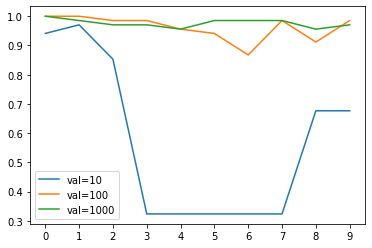

In [30]:
# Visualize validation accuracy
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'val={size}')
    
plt.xticks(np.arange(10))
plt.legend()

plt.show()

It is not always clear that adding new layers will result in better performance, which is something we need to consider. However, as seen from the plot above, the model performed better when the layer size was 1000. The next step will be to apply regularization techniques to the new added layer to improve performance if possible.

In [31]:
# Number of units in the dense layer
size = 1000

# Regularization and dropout

The next experiment aims to improve the model's performance by adding a dropout layer and looping over different dropout rates of 0.0, 0.2, 0.5, and 0.8. A dropout layer is a technique that randomly drops out a certain number of neurons during training, this prevent the model from overfitting by avoiding complex co-adaptations on the training data. By adding a dropout layer to the model, we aim to increase the model's capacity to generalize well on unseen data.

In addition to adding a dropout layer, we will also loop over different dropout rates. The dropout rate represents the fraction of neurons that are dropped out during training. By looping over different dropout rates, we aim to find the optimal dropout rate that results in the best performance on the validation set.

This experiment will help us to understand the impact of the dropout rate on the model's performance and how adding a dropout layer can improve the model's ability to generalize well on unseen data.

In [32]:
# Function to define model with learning rate, dense layer and dropout layer
def define_model(learning_rate=0.001, size_inner=100, dropout_rate=0.5):
    # Build base model
    base_model = tf.keras.applications.xception.Xception(include_top=False)
    base_model.trainable = False
    
    # Create input and output layer
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(size_inner, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create model for training
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])
    
    return model

In [33]:
# Create checkpoint to save best model for version 3
filepath = './checkpoint/xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             save_best_only=True,
                                             monitor='val_accuracy',
                                             mode='max')


# Dict to store results
scores = {}

# List of dropout rates
droprates = [0.0, 0.2, 0.5, 0.8]

for droprate in droprates:
    print(droprate)
    
    # Set the best values of learning rate and inner layer size based on previous experiments
    model = define_model(learning_rate=learning_rate,
                         size_inner=size,
                         dropout_rate=droprate)
    
    # Train for longer (epochs=30) cause of dropout regularization
    history = model.fit(train_ds,
                        epochs=30,
                        validation_data=val_ds,
                        callbacks=[checkpoint])
    scores[droprate] = history.history
    
    print()
    print()

0.0
Epoch 1/30
229/229 [==============================] - 9s 28ms/step - loss: 29.2338 - accuracy: 0.9591 - val_loss: 22.5322 - val_accuracy: 0.9853
Epoch 2/30
229/229 [==============================] - 6s 26ms/step - loss: 19.7585 - accuracy: 0.9629 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/30
229/229 [==============================] - 6s 24ms/step - loss: 15.3736 - accuracy: 0.9711 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/30
229/229 [==============================] - 6s 25ms/step - loss: 39.3888 - accuracy: 0.9782 - val_loss: 150.2721 - val_accuracy: 0.9265
Epoch 5/30
229/229 [==============================] - 6s 25ms/step - loss: 4.4095 - accuracy: 0.9896 - val_loss: 10.7660 - val_accuracy: 0.9706
Epoch 6/30
229/229 [==============================] - 5s 24ms/step - loss: 2.3657 - accuracy: 0.9913 - val_loss: 9.9628 - val_accuracy: 0.9706
Epoch 7/30
229/229 [==============================] - 5s 23ms/step - loss: 0.4020 - accuracy: 0.9934 - val_loss: 9.8772 - 

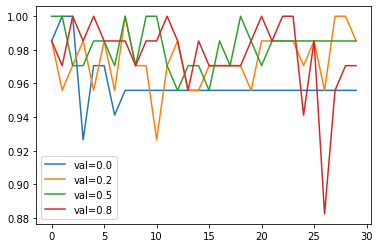

In [34]:
# Visualize validation accuracy on different dropout rates
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'val={droprate}')

plt.legend()

plt.show()

It seems that adding a dropout layer did not help improve the model's performance and therefore it is better to leave it out.

## Data augmentation

This experiment aims to improve the model's performance by using data augmentation techniques such as rotation, shifting, shearing, zooming and flipping. These techniques artificially increase the size of the training set and improve the model's ability to generalize well on unseen data.

In [35]:
# Create image generator for training with image augmentation
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             rotation_range=30,
                             width_shift_range=10.0,
                             height_shift_range=10.0,
                             shear_range=10,
                             zoom_range=0.1,
                             vertical_flip=True)

# Training data
train_ds = datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical')

# Validation data
val_ds = datagen.flow_from_directory(directory=test_dir,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                          class_mode='categorical',
                                          shuffle=False)

Found 1832 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [36]:
# Function to define model with learning rate and dense layer
def define_model(learning_rate=0.001, size_inner=100):
    # Build base model
    base_model = tf.keras.applications.xception.Xception(include_top=False)
    base_model.trainable = False
    
    # Create input and output layer
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(size_inner, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create model for training
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])
    
    return model

In [37]:
# Create checkpoint to save best model for version 4
filepath = './checkpoint/xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             save_best_only=True,
                                             monitor='val_accuracy',
                                             mode='max')


# Build model
model = define_model(learning_rate=learning_rate,
                     size_inner=size)

# Train the model by setting hyperparameters value based on previous experiments
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/30
229/229 [==============================] - 18s 68ms/step - loss: 24.6550 - accuracy: 0.9290 - val_loss: 8.9825 - val_accuracy: 0.9706
Epoch 2/30
229/229 [==============================] - 15s 64ms/step - loss: 11.5129 - accuracy: 0.9405 - val_loss: 7.4103 - val_accuracy: 0.9265
Epoch 3/30
229/229 [==============================] - 15s 63ms/step - loss: 1.8252 - accuracy: 0.9520 - val_loss: 0.5018 - val_accuracy: 0.9412
Epoch 4/30
229/229 [==============================] - 15s 64ms/step - loss: 1.4226 - accuracy: 0.9285 - val_loss: 1.4040 - val_accuracy: 0.8529
Epoch 5/30
229/229 [==============================] - 14s 61ms/step - loss: 0.6247 - accuracy: 0.9296 - val_loss: 0.9259 - val_accuracy: 0.8971
Epoch 6/30
229/229 [==============================] - 15s 65ms/step - loss: 0.4787 - accuracy: 0.9181 - val_loss: 0.1939 - val_accuracy: 0.8824
Epoch 7/30
229/229 [==============================] - 14s 62ms/step - loss: 1.7300 - accuracy: 0.9148 - val_loss: 9.1987 - val_accurac

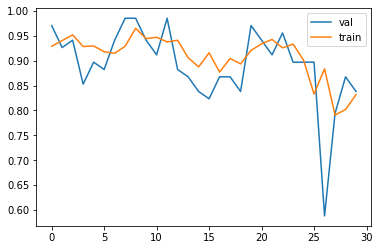

In [38]:
# Visualize train and validation accuracy
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
plt.legend()

plt.show()

Data augmentation is not helpful to improve the model performance.

## Larger image size

The next experiment aims to improve the model's performance by using larger image size of 299x299 pixels, this can provide the model with more information and help it to learn more detailed features and improve the model's ability to generalize well on unseen data. However, it's important to consider the trade-off between the increase in the model's performance and the increase in the computational cost.

In [39]:
# Set larger image input size
IMG_SIZE = (299, 299)
BATCH_SIZE = 8

In [40]:
# Create data generator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training data
train_ds = datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical')

# Validation data
val_ds = datagen.flow_from_directory(directory=test_dir,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                          class_mode='categorical',
                                          shuffle=False)

Found 1832 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [41]:
# Function to define model with learning rate, dense layer, and larger image size (299, 299)
def define_model(learning_rate=0.001, size_inner=100):
    # Build base model
    base_model = tf.keras.applications.xception.Xception(include_top=False)
    base_model.trainable = False
    
    # Create input and output layer
    inputs = tf.keras.layers.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(size_inner, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create model for training
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])
    
    return model

In [42]:
# Create checkpoint to save best model for version 5
filepath = './checkpoint/xception_v5_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')


# Build model
model = define_model(learning_rate=learning_rate,
                     size_inner=size)

# Train the model for 15 epochs with learning rate (0.1), dense layer size (1000)
history = model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/15
229/229 [==============================] - 14s 50ms/step - loss: 12.4552 - accuracy: 0.9580 - val_loss: 0.6475 - val_accuracy: 0.9853
Epoch 2/15
229/229 [==============================] - 11s 47ms/step - loss: 11.4809 - accuracy: 0.9793 - val_loss: 21.6571 - val_accuracy: 0.9853
Epoch 3/15
229/229 [==============================] - 10s 45ms/step - loss: 6.0673 - accuracy: 0.9880 - val_loss: 3.0356 - val_accuracy: 0.9853
Epoch 4/15
229/229 [==============================] - 11s 46ms/step - loss: 0.6101 - accuracy: 0.9956 - val_loss: 2.3523 - val_accuracy: 0.9559
Epoch 5/15
229/229 [==============================] - 10s 45ms/step - loss: 0.1109 - accuracy: 0.9967 - val_loss: 0.4646 - val_accuracy: 0.9853
Epoch 6/15
229/229 [==============================] - 10s 45ms/step - loss: 0.0017 - accuracy: 0.9989 - val_loss: 0.4652 - val_accuracy: 0.9853
Epoch 7/15
229/229 [==============================] - 10s 45ms/step - loss: 0.0017 - accuracy: 0.9989 - val_loss: 0.4596 - val_accura

The current experiment was successful in achieving an accuracy of 0.985, which is trained with image size (299, 299). This is a significant improvement in the model's performance and suggests that using larger image size can be effective in improving the model's accuracy.

## Model predictions

We will now use the model to make predictions on the validation dataset to evaluate its performance

In [45]:
# Make predictions
y_pred_probs = model.predict(val_ds)
y_pred_probs[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [50]:
# Get the predictions
y_pred = y_pred_probs.argmax(axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [51]:
# Get test labels
y_true = val_ds.labels
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [48]:
# Function to plot confusion matrix
def show_confusion_matrix(cm, classes, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

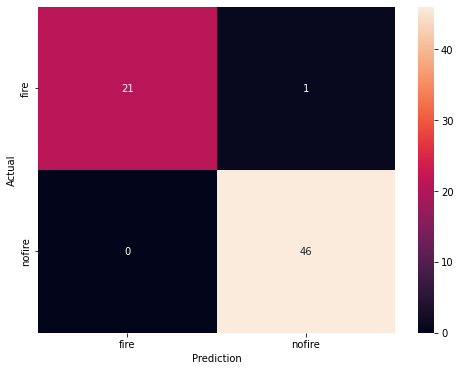

In [49]:
# Compute confusion matrix
confusion_mtx = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=len(class_names))

# Show confusion matrix
show_confusion_matrix(confusion_mtx, class_names, figsize=(8, 6))

The matrix shows the number of correct and incorrect predictions made by the model for each class. In this case, the model predicted 21 correct images from the "fire" class and 46 correct images from the "nofire" class. However, it misclassified 1 image that belongs to the "fire" class but was predicted as "nofire".

Now that the model has been trained, the next step is to evaluate the model's performance on unseen data. This can be done by using the test data and evaluating the model's predictions on this data. It's important to evaluate the model's performance on unseen data as it provides an estimate of how well the model will perform on new, unseen data in the future.